In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('./data/train.csv')
data_exam = pd.read_csv('./data/test.csv')

### Функции очистки данных

In [4]:
def drop_healthcare(ds):
    return ds.drop(columns=['Healthcare_1'], axis=1)

In [5]:
def drop_kitchen(ds):
    return ds.drop(columns=['KitchenSquare'], axis=1)

In [6]:
def clear_houseyear(ds):
    rows_to_clear = ds[(ds.HouseYear < 1900) | (ds.HouseYear > 2020)]
    df_valid = ds[(ds.HouseYear >= 1900) & (ds.HouseYear <= 2020)]
    
    max_year = df_valid.HouseYear.max()
    min_year = df_valid.HouseYear.min()

    for index, row in rows_to_clear.iterrows():
        sqr_delta = row.Square / row.Rooms
        year = df_valid.loc[(df_valid.Id != row.Id) & 
                        (df_valid.DistrictId == row.DistrictId) & 
                        (df_valid.Rooms == row.Rooms) & 
                        (df_valid.Square <= row.Square + sqr_delta) & (df_valid.Square >= row.Square - sqr_delta)
                       ].HouseYear.mean()

        ds.loc[index, 'HouseYear'] = np.clip(np.int64(year), min_year, max_year)
    
    return ds

In [7]:
def fill_lifesquare(ds):
    ds.LifeSquare = np.where((ds.LifeSquare < 8) | (ds.LifeSquare > ds.Square), ds.Square, ds.LifeSquare)
    return ds

In [8]:
def clear_housefloor(ds):
    rows_to_clear = ds[(ds.HouseFloor == 0) | (ds.HouseFloor > 90)]
    df_valid = ds[(ds.HouseFloor > 0) & (ds.HouseFloor <= 90)]
    max_floor = df_valid.HouseFloor.max()
    min_floor = df_valid.HouseFloor.min()

    for index, row in rows_to_clear.iterrows():
        floor = df_valid.loc[(df_valid.Id != row.Id) & 
                        (df_valid.DistrictId == row.DistrictId) & 
                        (df_valid.HouseYear == row.HouseYear)
                       ].HouseFloor.mean()
        
        if np.isnan(floor) or floor == 0:
            floor = df_valid.loc[(df_valid.Id != row.Id) & 
                        (df_valid.DistrictId == row.DistrictId)
                       ].HouseFloor.mean()
            
        if np.isnan(floor) or floor == 0:
            floor = df_valid.loc[(df_valid.Id != row.Id) & 
                        (df_valid.HouseYear == row.HouseYear)
                       ].HouseFloor.mean()
            
        if np.isnan(floor) or floor == 0:
            floor = 1
            
        ds.loc[index, 'HouseFloor'] = np.clip(np.int64(floor), min_floor, max_floor)
    
    return ds

### Очистка, разбиение на сеты

In [9]:
data = drop_healthcare(data)
data = drop_kitchen(data)
data = clear_houseyear(data)

data_exam = drop_healthcare(data_exam)
data_exam = drop_kitchen(data_exam)
data_exam = clear_houseyear(data_exam)

### Очистка руками

#### Rooms / train set

In [10]:
data.Rooms.describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

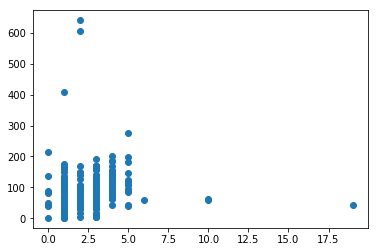

In [11]:
plt_ = plt.scatter(data.Rooms, data.Square)

In [12]:
data.loc[data.Rooms > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,22,22.0,2002,0.090799,B,B,74,19083,2,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,17,17.0,2014,0.007122,B,B,1,264,0,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,7,9.0,1969,0.033494,B,B,66,10573,1,3,8,B,229661.964416
8849,14865,9,10.0,60.871266,38.420681,3,2.0,1994,0.161532,B,B,25,5648,1,2,4,B,172329.270863


In [13]:
data.loc[data.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,4,3.0,2016,0.075424,B,B,11,3097,0,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,2,3.0,2008,0.211401,B,B,9,1892,0,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,13,0.0,1977,0.211401,B,B,9,1892,0,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,16,0.0,2015,0.118537,B,B,30,6207,1,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,4,0.0,1977,0.243205,B,B,5,1564,0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9,16.0,1982,0.127376,B,B,43,8429,3,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,5,15.0,1977,0.211401,B,B,9,1892,0,0,1,B,219281.918007


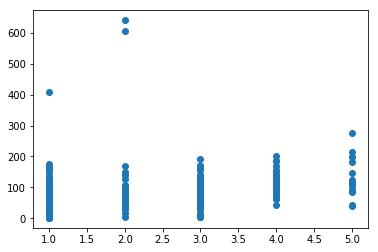

In [14]:
data.loc[377, 'Rooms'] = 2
data.loc[1454, 'Rooms'] = 1
data.loc[2170, 'Rooms'] = 2
data.loc[8849, 'Rooms'] = 2

data.loc[1397, 'Rooms'] = 4
data.loc[1981, 'Rooms'] = 5
data.loc[2269, 'Rooms'] = 1
data.loc[3911, 'Rooms'] = 2
data.loc[4366, 'Rooms'] = 3
data.loc[4853, 'Rooms'] = 1
data.loc[6149, 'Rooms'] = 1
data.loc[4853, 'Rooms'] = 1
data.loc[8834, 'Rooms'] = 3

plt_ = plt.scatter(data.Rooms, data.Square)

##### Rooms / test set

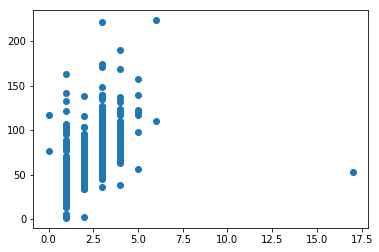

In [15]:
plt_ = plt.scatter(data_exam.Rooms, data_exam.Square)

In [16]:
data_exam.loc[data_exam.Rooms > 10]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
3398,1435,111,17.0,52.866107,32.528342,15,17.0,1987,0.093443,B,B,23,4635,5,2,4,B


In [17]:
data_exam.loc[data_exam.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,3,3.0,1977,0.437885,B,B,23,5735,3,0,5,B
2524,10729,27,0.0,76.345154,42.820796,14,0.0,1977,0.017647,B,B,2,469,0,0,0,B


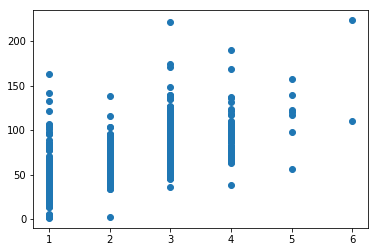

In [18]:
data_exam.loc[3398, 'Rooms'] = 1
data_exam.loc[2406, 'Rooms'] = 3
data_exam.loc[2524, 'Rooms'] = 2
plt_ = plt.scatter(data_exam.Rooms, data_exam.Square)

#### Square/ LIfeSquare

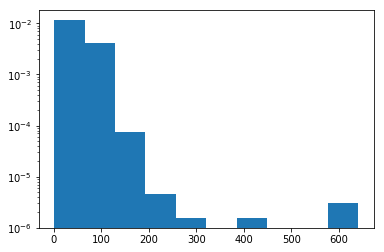

In [19]:
plt_ = plt.hist(data.Square, bins=10, density=True, log='y')

In [20]:
data[data.Square > 350]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2.0,604.705972,NaN,17,18.0,1977,0.161532,B,B,25,5648,1,2,4,B,187717.242538
4690,2307,102,1.0,409.425181,410.639749,4,4.0,2016,0.238617,B,B,26,3889,6,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,20,19.0,2019,0.000078,B,B,22,6398,141,3,23,B,133529.681562


In [21]:
data[data.Square <= 16]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,24,22.0,1977,0.127376,B,B,43,8429,3,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,18,1.0,1977,0.011654,B,B,4,915,0,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,3,25.0,2014,0.243205,B,B,5,1564,0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,40.805837,10,17.0,2013,0.211401,B,B,9,1892,0,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1,1.0,1977,0.150818,B,B,16,3433,4,4,5,B,369472.403061
4739,12676,81,3.0,13.784865,15.988889,4,5.0,1960,0.319809,B,B,25,4756,16,5,8,B,78388.806186
4853,3224,27,1.0,2.377248,0.873147,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,8,19.0,2016,0.211401,B,B,9,1892,0,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,3,1.0,1977,0.007122,B,B,1,264,0,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,79.767964,6,17.0,1977,0.007122,B,B,1,264,0,0,1,B,237716.681261


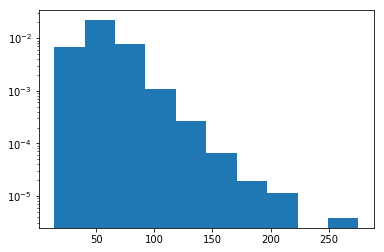

In [22]:
data.loc[4262, 'Square'] = 60.4
data.loc[4690, 'Square'] = 40.9
data.loc[6977, 'Square'] = 64.1

data.loc[212, 'Square'] = 67.6
data.loc[212, 'LifeSquare'] = 54.9

data.loc[1316, 'Square'] = 46.3
data.loc[1316, 'LifeSquare'] = 46.3 - 19.6

data.loc[1608, 'Square'] = 46
data.loc[1608, 'LifeSquare'] = 26

data.loc[3280, 'Square'] = 44
data.loc[3280, 'LifeSquare'] = 41

data.loc[3413, 'Square'] = 55.4
data.loc[3413, 'LifeSquare'] = 51

data.loc[4739, 'Rooms'] = 1

data.loc[4853, 'Square'] = 23.7
data.loc[4853, 'LifeSquare'] = 16

data.loc[4900, 'Square'] = 56
data.loc[4900, 'LifeSquare'] = 43

data.loc[6392, 'Square'] = 45
data.loc[6392, 'LifeSquare'] = 32

data.loc[8030, 'Square'] = 80
data.loc[8030, 'LifeSquare'] = 48

data.loc[8283, 'Square'] = 26.5
data.loc[8283, 'LifeSquare'] = 20

data.loc[9294, 'Square'] = 52.5
data.loc[9294, 'LifeSquare'] = 29

data.loc[9613, 'Square'] = 46
data.loc[9613, 'LifeSquare'] = 45


plt_ = plt.hist(data.Square, bins=10, density=True, log='y')

In [23]:
data.LifeSquare.fillna(0.01, inplace=True)

In [24]:
data[data.LifeSquare > 1000]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,7480.592129,9,17.0,2016,0.017647,B,B,2,469,0,0,0,B,217357.492366


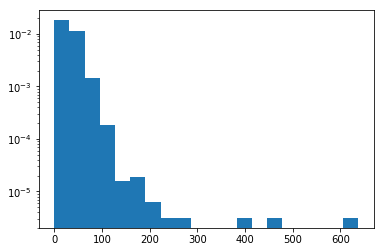

In [25]:
data.loc[4328, 'LifeSquare'] = 74.8
plt_ = plt.hist(data.LifeSquare, bins=20, density=True, log='y')

In [26]:
data[data.LifeSquare > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4690,2307,102,1.0,40.900000,410.639749,4,4.0,2016,0.238617,B,B,26,3889,6,3,6,B,90470.430830
6977,11602,30,2.0,64.100000,638.163193,20,19.0,2019,0.000078,B,B,22,6398,141,3,23,B,133529.681562
8437,15886,85,3.0,78.059331,461.463614,12,16.0,1998,0.037178,B,B,52,11217,1,1,7,B,394253.299978


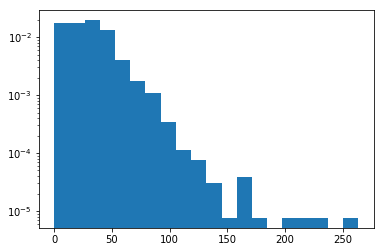

In [27]:
data.loc[4690, 'LifeSquare'] = 41
data.loc[6977, 'LifeSquare'] = 64
data.loc[8437, 'LifeSquare'] = 46

plt_ = plt.hist(data.LifeSquare, bins=20, density=True, log='y')

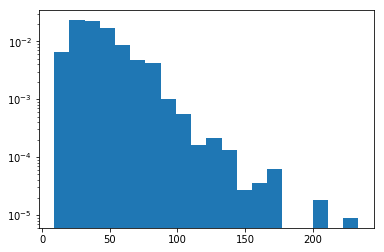

In [28]:
data = fill_lifesquare(data)
plt_ = plt.hist(data.LifeSquare, bins=20, density=True, log='y')

##### data_exam

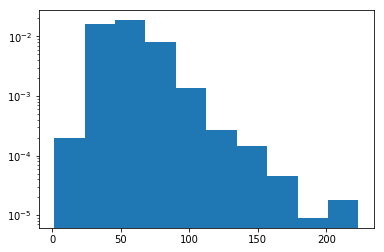

In [29]:
plt_ = plt.hist(data_exam.Square, bins=10, density=True, log='y')

In [30]:
data_exam[data_exam.Square <= 16]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
2,5480,190,1.0,13.597819,15.948246,2,5.0,1909,0.000000,B,B,30,7538,87,5,5,B
66,9011,53,1.0,1.378543,1.353573,1,1.0,1977,0.049637,B,B,34,7759,0,1,3,B
608,16401,30,1.0,2.645046,4.338755,2,1.0,1977,0.000078,B,B,22,6398,141,3,23,B
837,2138,27,1.0,5.647458,1.501582,1,1.0,1977,0.017647,B,B,2,469,0,0,0,B
1165,10120,6,1.0,5.100672,3.861780,3,1.0,1977,0.243205,B,B,5,1564,0,0,0,B
3697,15435,21,1.0,13.305531,9.495367,6,5.0,1965,0.194489,B,B,47,8004,3,3,5,B
4490,1165,27,1.0,2.372101,1.899119,2,17.0,1977,0.011654,B,B,4,915,0,0,0,B
4540,7855,6,1.0,4.967143,2.968086,3,1.0,2018,0.243205,B,B,5,1564,0,0,0,B
4713,170,6,2.0,2.900586,61.468563,18,17.0,2014,0.243205,B,B,5,1564,0,0,0,B
4902,1420,45,1.0,1.975769,2.900371,1,1.0,1977,0.195781,B,B,23,5212,6,3,2,B


In [31]:
data_exam.loc[66, 'Square'] = 13.7
data_exam.loc[66, 'LifeSquare'] = 13.5
data_exam.loc[608, 'Square'] = 26.4
data_exam.loc[837, 'Square'] = 15
data_exam.loc[1165, 'Square'] = 38
data_exam.loc[3697, 'Square'] = 13.3
data_exam.loc[4490, 'Square'] = 23.7
data_exam.loc[4540, 'Square'] = 29.6
data_exam.loc[4713, 'Square'] = 29
data_exam.loc[4902, 'Square'] = 29

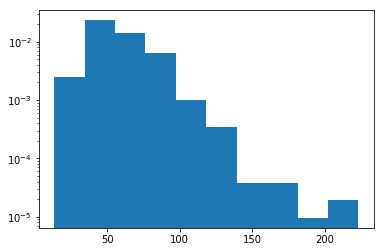

In [32]:
plt_ = plt.hist(data_exam.Square, bins=10, density=True, log='y')

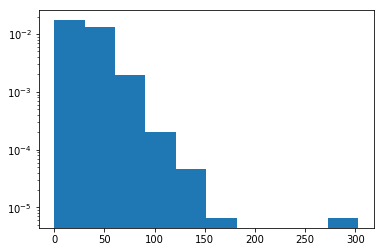

In [33]:
data_exam.LifeSquare.fillna(0.01, inplace=True)
plt_ = plt.hist(data_exam.LifeSquare, bins=10, density=True, log='y')

In [34]:
data_exam[data_exam.LifeSquare > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
410,11533,94,2.0,48.713443,303.071094,5,12.0,1974,0.521867,B,B,25,6149,0,0,0,B


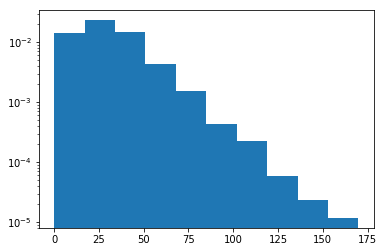

In [35]:
data_exam.loc[410, 'LifeSquare'] = 30.3
plt_ = plt.hist(data_exam.LifeSquare, bins=10, density=True, log='y')

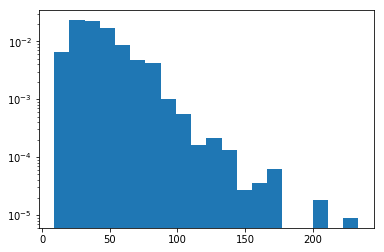

In [36]:
data_exam = fill_lifesquare(data_exam)
plt_ = plt.hist(data.LifeSquare, bins=20, density=True, log='y')

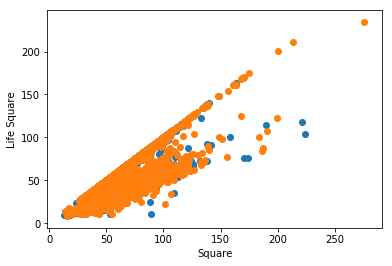

In [37]:
plt.xlabel('Square')
plt.ylabel('Life Square')
plt_ = plt.scatter(data_exam.Square, data_exam.LifeSquare)
plt_ = plt.scatter(data.Square, data.LifeSquare)

#### Дальнейшая очистка / train set

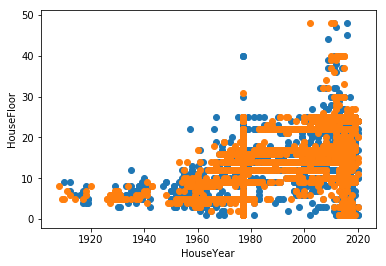

In [38]:
data = clear_housefloor(data)
data_exam = clear_housefloor(data_exam)
plt.ylabel('HouseFloor')
plt.xlabel('HouseYear')
plt_ = plt.scatter(data.HouseYear, data.HouseFloor)
plt_ = plt.scatter(data_exam.HouseYear, data_exam.HouseFloor)

In [39]:
data.Floor = np.where(data.Floor > data.HouseFloor, data.HouseFloor, data.Floor)
data_exam.Floor = np.where(data_exam.Floor > data_exam.HouseFloor, data_exam.HouseFloor, data_exam.Floor)

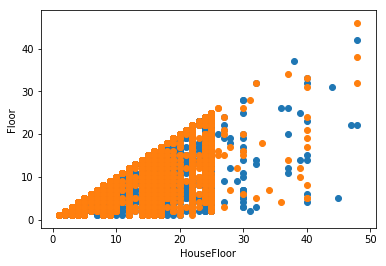

In [40]:
plt.xlabel('HouseFloor')
plt.ylabel('Floor')
plt_ = plt.scatter(data.HouseFloor, data.Floor)
plt_ = plt.scatter(data_exam.HouseFloor, data_exam.Floor)

#### Сохранение в *_cleared.csv

In [41]:
data.to_csv('./data/train_clear_.csv', index=None)
data_exam.to_csv('./data/test_clear_.csv', index=None)